In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from bgreference import hg38
import pickle
from collections import defaultdict
from tqdm import tqdm

# Create dictionary with probabilities

We run deconstructsigs in all samples only allowing for those signatures already described to be active in the specific tumor type

In [ ]:

all_files = glob('/workspace/projects/intogen_2017/test/signature_fitting/out/*.out.limitted_COSMIC.txt')

signatures_file = '/workspace/projects/intogen_2017/data/signatures/SigProfiler_COSMIC.deconstructsigs.tsv'
W = pd.read_csv(signatures_file, sep="\t", index_col=0, header=0)
keep_all = []
W = W.T

for input_file in tqdm(all_files):
    
    outpath_file = input_file.replace('.txt', '.prob.gz')
    # read weights
    H = pd.read_csv(input_file, header=0, sep='\t')

    # compute probabilities
    # go over each sample in H matrix and compute the probability for each mutation type in a tri-nuc context
    frames = []  # to collect results sample-wise
    flag = 0
    for idx, row in H.iterrows():  # go over each sample
        sample = row['sample_id']
        sig_dic = {}
        allsigs = []

        # get the exposure (i.e total number of mutations belong to each signature) value for the particular sample from H matrix
        for col in H.columns:
            if col not in ['sample_id', 'SSE', 'mutation_count']:
                sig_dic[col] = row[col] * row[
                    'mutation_count']  # save the exposuse value in a dictionary per signature name
                allsigs.append(col)  # save the signature names

        # multiple the exposure (from H) with the W matrix
        a = W.copy()  # take a copy of the W matrix (which is the extracted signatures - not sample specific)
        for sig in allsigs:
            a[sig] *= sig_dic[
                sig]  # mutiply the signature columns with the corresponding signature exposure in that particular sample

        # compute the row sum for normalization (i.e sum of values across signature for each mutation/context type)
        a['row_sum'] = a[allsigs].sum(axis=1)

        # normalize the row values with the row sum to driver
        # the probabilities for different signatures for each mutation type
        new = a[allsigs].div(a['row_sum'], axis=0)[allsigs]

        # add info columns
        new['Mutation_type'] = new.index
        new['Sample'] = sample

        # sort the columns
        columns = ['Sample', 'Mutation_type'] + allsigs

        new = new[columns]

        # save the results for each samples in a dataframe
        if flag == 0:
            frames = [new]
            flag += 1
        else:
            frames.append(new)

    results_new = pd.concat(frames)
    results_new.to_csv(outpath_file, sep='\t', compression = 'gzip')
    keep_all.append(results_new)

In [ ]:
mut_probs = pd.concat(keep_all)
mut_probs.fillna(0).drop_duplicates(inplace = True)

mut_probs.to_csv('/workspace/projects/intogen_2017/test/signature_fitting/samples_probability_all_sigs.tsv.gz', 
                sep ='\t', index = True, header = True, compression = 'gzip')

samples_with_deconstructsigs = mut_probs['Sample'].drop_duplicates().tolist()

## create final dictionary

In [ ]:
from collections import OrderedDict
import numpy as np
import gzip
import pickle

In [ ]:
def f(row):
    return OrderedDict(row)
    
all_sigs = ['Signature.1', 'Signature.10',
       'Signature.11', 'Signature.12', 'Signature.13', 'Signature.14',
       'Signature.15', 'Signature.16', 'Signature.17', 'Signature.18',
       'Signature.2', 'Signature.20', 'Signature.21', 'Signature.22',
       'Signature.23', 'Signature.24', 'Signature.26', 'Signature.28',
       'Signature.3', 'Signature.30', 'Signature.4', 'Signature.5',
       'Signature.6', 'Signature.7', 'Signature.8', 'Signature.9']

signature_order = ['Signature.{}'.format(s) for s in np.arange(1, 31)]

signature_order_final = [s for s in signature_order if s not in ['Signature.19', 'Signature.29', 'Signature.27', 'Signature.25']]

all_context = mut_probs['Mutation_type'].drop_duplicates().tolist()
dic_probability_samples = defaultdict(lambda : defaultdict(lambda : defaultdict(float)))
for sample, d in tqdm(mut_probs.fillna(0).groupby(by='Sample')):
    if len(d)==96:
        dic_probability_samples[sample] = d[signature_order_final].apply(f, axis=1).to_dict()

pickle.dump(dict(dic_probability_samples), gzip.open('/workspace/projects/intogen_2017/test/signature_fitting/samples_probability_all_sigs.dict.pckl.gz', 
                                                    'wb'))

# Read all driver mutations and add ML

In [ ]:
import numpy as np
import os

In [ ]:
# create order format simiilar to sigprofiler
def create_snv_class(df):

    pyr = ['C', 'T']
    rev = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    x=df['TRIPLET']
    
    if x[1] in pyr:
        out = '{}[{}>{}]{}'.format(x[0], x[1], df['alt'], x[2])
    else:
        out = '{}[{}>{}]{}'.format(rev[x[2]], rev[x[1]], rev[df['alt']], rev[x[0]])
    return out

def get_ML(df):
    vals = dic_probability_samples[df['sample_id']][df['VARIANT_CLASS']]
    return max(vals, key=vals.get)

def get_vector(df):
    return list(dic_probability_samples[df['sample_id']][df['VARIANT_CLASS']].values())

In [ ]:
# read boostDM in cancer driver genes
f = '/workspace/datasets/boostdm_runs/20200205/observed_predictions_with_samples/all_info_drivers.tsv.gz'
merged_df = pd.read_csv(f, sep ='\t')
merged_df = merged_df[['gene', 'chr', 'pos', 'ref', 'alt', 'sample_id', 'boostDM_class', 'COHORT', 'aachange']]
merged_df['cancer_gene'] = True

In [ ]:
# merge and get triplet and variant
merged_df = merged_df[merged_df['sample_id'].isin(dic_probability_samples.keys())]
merged_df = merged_df[merged_df['ref'].isin(['A', 'C', 'G', 'T']) & merged_df['alt'].isin(['A', 'C', 'G', 'T'])]
merged_df['TRIPLET'] = merged_df.apply(lambda x : hg38(x['chr'], x['pos']-1, 3), axis = 1)
merged_df['VARIANT_CLASS'] = merged_df.apply(create_snv_class, axis = 1)

In [ ]:
merged_df['MATCHED'] = merged_df.apply(lambda x : 'PASS' if x['ref']==x['TRIPLET'][1] else 'REMOVE', axis = 1)
merged_df = merged_df[merged_df['MATCHED']=='PASS']

In [ ]:
merged_df = merged_df[~merged_df['VARIANT_CLASS'].isin(['A[C>A]N', 'N[T>G]C'])]

In [ ]:
# get ML
merged_df['Sigs_vector'] = merged_df.apply(get_vector, axis = 1)
merged_df['ML'] = merged_df.apply(get_ML, axis = 1)

# Driver mutations

In [ ]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows=100
pd.options.display.max_columns=100
import numpy as np
from tqdm import tqdm
from matplotlib.lines import Line2D
import numpy as np, scipy.stats as st
import seaborn as sns
from matplotlib import gridspec
import pickle

plt.rcParams['font.sans-serif'] = ['arial']
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'arial'
plt.rcParams['mathtext.rm'] = 'arial'

import bgreference
from itertools import product
import json

list_signatures = [x[0]+"."+str(x[1]) for x in list(product(["Signature"],range(1,31)))]


In [ ]:
stats_cohort = '/workspace/projects/intogen_2017/pipeline/datasets/hg38_vep92_develop/stats_cohorts/stats_cohorts.tsv'


In [ ]:
dictionary_colors = {"Signature.1": "#9edae5", "Signature.2": "#ffbb78",
                     "Signature.3": "#98df8a", "Signature.4": "#e377c2",
                     "Signature.5": "#D21F71", "Signature.6": "#ff7f0e",
                     "Signature.7": "#ff9896", "Signature.8": "#2ca02c",
                     "Signature.9": "#d62728", "Signature.10": "#B7D21F",
                     "Signature.11": "#8c564b", "Signature.12": "#c7c7c7",
                     "Signature.13": "#1FD2CD", "Signature.14": "#1F32D2",
                     "Signature.15": "#ff9896", "Signature.16": "#C71FD2",
                     "Signature.17": "#1f77b4", "Signature.18": "#6F3232",
                     "Signature.19": "#381144", "Signature.20": "#ffbb78",
                     "Signature.21": "#bcbd22", "Signature.22": "#8c564b",
                     "Signature.23": "#1f77b4", "Signature.24": "#d62728",
                     "Signature.25": "#9edae5", "Signature.26": "#c5b0d5",
                     "Signature.27": "#2ca02c", "Signature.28": "#17becf",
                     "Signature.29": "#f7b6d2", "Signature.30": "#c49c94"}


In [ ]:
merged_df["ID"] = merged_df.apply(lambda x : '{}_{}_{}_{}'.format(x['gene'], x['aachange'],
                                                                      x['ref'], x['alt']), axis = 1)

In [ ]:
df_stats = pd.read_csv(stats_cohort, sep ='\t')
dic_stats = dict(zip(df_stats['COHORT'], df_stats['cancer_type']))

In [ ]:
merged_df['cancer_type'] = merged_df['COHORT'].map(dic_stats)
driver_muts = merged_df[merged_df['boostDM_class']]
pass_muts = merged_df[~merged_df['boostDM_class']]

In [ ]:

# this will create a new dataframe with the count of samples and the mean exposures per cohort
grouped = driver_muts.groupby(by=['cancer_type', 'ID'], as_index=False)
aggregated_probs = list((k[0], k[1], np.sum(v["Sigs_vector"].tolist(), axis = 0)/len(v)) for k, v in grouped)

counted_samples = driver_muts.groupby(by=['cancer_type', 'ID'], as_index=False).agg({'sample_id':"count"})
count_probs = pd.DataFrame(aggregated_probs, columns= ['cancer_type', 'ID', 'signatures'])

merged_driver_muts = pd.merge(count_probs, counted_samples)

# this will create a new dataframe with the count of samples and the mean exposures per cohort
grouped = pass_muts.groupby(by=['cancer_type', 'ID'], as_index=False)
aggregated_probs = list((k[0], k[1], np.sum(v["Sigs_vector"].tolist(), axis = 0)/len(v)) for k, v in grouped)

counted_samples = pass_muts.groupby(by=['cancer_type', 'ID'], as_index=False).agg({'sample_id':"count"})
count_probs_pass = pd.DataFrame(aggregated_probs, columns= ['cancer_type', 'ID', 'signatures'])

merged_pass_muts = pd.merge(count_probs_pass, counted_samples)

sorted_df = merged_driver_muts.sort_values(by='sample_id', ascending = False)
sorted_df.reset_index(inplace = True)

In [ ]:
dic_size = defaultdict(int)
for mut, data in sorted_df.groupby(by='ID'):
    all_samples_mutated = data['sample_id'].sum()
    dic_size[mut] = all_samples_mutated

sorted_muts = sorted(dic_size, key=dic_size.get, reverse= True)
test = sorted_df[sorted_df['ID'].isin(sorted_muts)]

In [ ]:
dic_vals = defaultdict(dict)
dic_sigs = defaultdict(dict)
dic_sigs_df = defaultdict(dict)
dic_sum_samples = defaultdict(dict)
dic_sum_samples_ttype = defaultdict(dict)

for (ttype, mut), data  in test.groupby(by=['cancer_type', 'ID']):
    
    list_sigs_exp = data[data['cancer_type']==ttype]['signatures'].tolist()[0]
    max_val = np.amax(list_sigs_exp)
    indx =  np.argmax(list_sigs_exp)
    max_sig = signature_order_final[indx]
    dic_vals[mut][ttype]=max_val
    dic_sigs[mut][ttype]=max_sig
    dic_sigs_df[mut][ttype]=int(max_sig.split('.')[-1])

for mut, data in test.groupby(by='ID'):
    
    dic_sum_samples[mut]= data['sample_id'].sum()
    
    for ttype, d in data.groupby(by='cancer_type'):
        dic_sum_samples_ttype[mut][ttype]= d['sample_id'].sum()

In [ ]:
toplot_full = pd.DataFrame(dic_vals).fillna(0).T.loc[sorted_muts]
n_mutations = 20

# Plot

In [ ]:
# subset
toplot4 = toplot_full.T[toplot_full.sum()>5].T
toplot4.columns = sorted(toplot4.columns)

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(12, 7.75)

toplot = toplot_full.head(n_mutations)
toplot4 = toplot.T[toplot.sum()>5].T
toplot4.columns = sorted(toplot4.columns)
gs = gridspec.GridSpec(figure=fig,ncols=2,nrows=n_mutations,width_ratios=[25,1])
gs.update(hspace=0.01,wspace=0.05)
axis = []


all_ttypes = toplot4.columns

# update axis with number of mutations
for i in range(0,(n_mutations)*2):
    axis.append(plt.subplot(gs[i]))

all_sigs = set()
for i in range(0,len(axis),2):

    ax = axis[i]

    # Plot scatter
    x_pos =  np.arange(len(toplot4.T))
    y_pos = np.zeros(len(toplot4.T))

    gene_index = i // 2
    
    mut_specific = toplot4.index.tolist()[gene_index]

    values = [50*np.log2(dic_sum_samples_ttype[mut_specific].get(ttype, 0)) for ttype in toplot4.columns]

    list_colors = [dictionary_colors[dic_sigs[mut_specific][col]] if col in dic_sigs[mut_specific] else 'white' for col in toplot4.columns ]
    
    list_sigs_final = set([dic_sigs[mut_specific][col] for col in toplot4.columns  if col in dic_sigs[mut_specific]  ])
    for sigl in list_sigs_final:
        all_sigs.add(sigl)
    
    ax.set_ylabel(mut_specific,fontsize=10,rotation=0,verticalalignment="center",horizontalalignment='right')

    ax.axhline(y=0,xmin=0.00,xmax=1,color='black',lw=0.25,alpha=0.5)
    
    for ix, expo in enumerate(toplot4.iloc[gene_index].tolist()):
        ax.scatter(x_pos[ix],y_pos[ix],s=values[ix],
                   color=list_colors[ix],linewidths=0.2,
                   edgecolors='darkred')

    ax.set_axisbelow(False)
    ax.set_yticks([])
    ax.set_xlim(-1,len(all_ttypes)+1)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Bar plot
maxv = np.nanmax(list(dic_sum_samples.values()))

for i in range(1,len(axis),2):
    ax = axis[i]
    
    # Plot bar
    gene_index = i // 2
    n_samples = dic_sum_samples[toplot4.index.tolist()[gene_index]]
    # Plot it
    ax.barh(i,n_samples,color='black',height=0.01,align='center')
    ax.annotate(xy=(n_samples+2,i),s=str(n_samples),fontsize=10, annotation_clip=False)
    ax.set_yticks([])
    ax.set_xticks([])
    ylims = ax.get_ylim()
    ax.set_ylim(ylims[0]-0.005,ylims[1]+0.005)
    ax.set_xlim(0,maxv)
    ax.set_ylabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

axis[-2].set_xticks([x for x in range(len(all_ttypes))])
_=axis[-2].set_xticklabels([x for x in all_ttypes],rotation=90,fontsize=3.25)        

axis[-2].tick_params(axis = 'x', labelsize =10  , pad=0.25,width=0.0, length = 0)
    
markers = [plt.Line2D([0,0],[0,0],color=dictionary_colors[sigc], marker='o', linestyle='') for sigc in all_sigs]
plt.legend(markers, all_sigs, numpoints=1, 
           bbox_to_anchor = [6,5], prop={'size': 13})

plt.show()

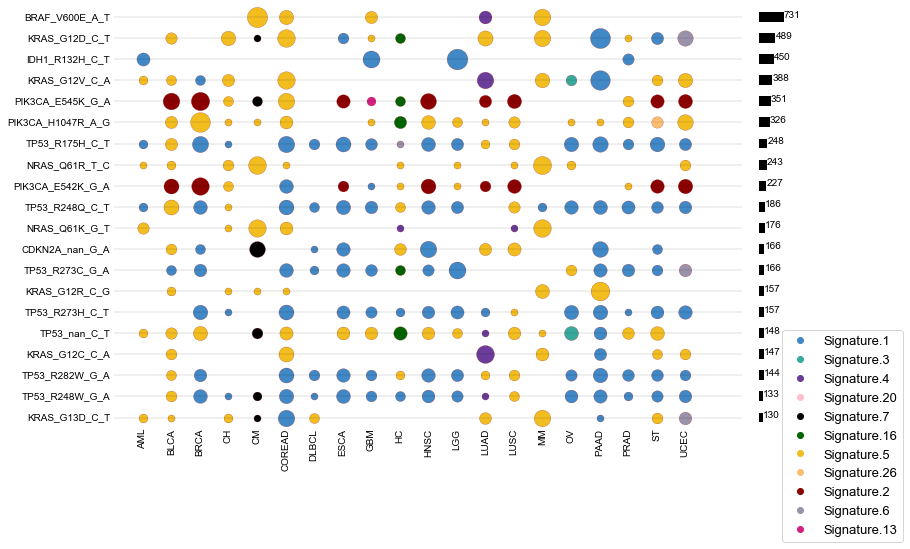